In [2]:
import os
import random
import numpy as np
import scipy.misc
import imageio

class GetData():
    def __init__(self, data_dir):
        images_list =[]
        labels_list = []

        self.source_list = []

        examples = 0
        print("loading images")
        label_dir = os.path.join(data_dir, "Labels")
        image_dir = os.path.join(data_dir, "Images")
        for label_root, dir, files in os.walk(label_dir):
            for file in files:
                if not file.endswith((".png", ".jpg", ".gif")):
                    continue
                try:
                    folder = os.path.relpath(label_root, label_dir)
                    image_root = os.path.join(image_dir, folder)


                    image = imageio.imread(os.path.join(image_root, file))
                    label = imageio.imread(os.path.join(label_root, file))

                    image = image[...,0][...,None]/255

                    label = label[...,0]>1
                    label = label[...,None]
                    label = label.astype(np.int64)

                    images_list.append(image)
                    labels_list.append(label)
                    examples = examples + 1
                except Exception as e:
                    print(e)
        print("finished loading images")
        self.examples = examples
        print("Number of examples found: ", examples)
        self.images = np.array(images_list)
        self.labels = np.array(labels_list)

    def next_batch(self, batch_size):

        if len(self.source_list) < batch_size:
            new_source = list(range(self.examples))
            random.shuffle(new_source)
            self.source_list.extend(new_source)

        examples_idx = self.source_list[:batch_size]
        del self.source_list[:batch_size]

        return self.images[examples_idx,...], self.labels[examples_idx,...]


Segmentation Models: using `keras` framework.
loading images
finished loading images
Number of examples found:  526
loading images
finished loading images
Number of examples found:  279
(526, 256, 256, 1)
(526, 256, 256, 1)


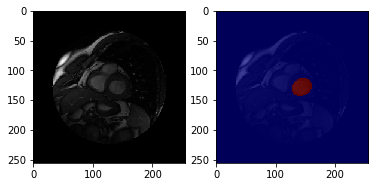

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

DATA_NAME = 'Data'
TRAIN_SOURCE = 'Train'
TEST_SOURCE = 'Test'

WORKING_DIR = os.getcwd()

TRAIN_DATA_DIR = os.path.join(WORKING_DIR, DATA_NAME, TRAIN_SOURCE)
TEST_DATA_DIR = os.path.join(WORKING_DIR, DATA_NAME, TEST_SOURCE)


train_data = GetData(TRAIN_DATA_DIR)
test_data = GetData(TEST_DATA_DIR)
print(train_data.images.shape)
print(train_data.labels.shape)

n = 100

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_data.images[n,:,:,0], 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(train_data.images[n,:,:,0], 'gray', interpolation='none')
plt.imshow(train_data.labels[n,:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.show()


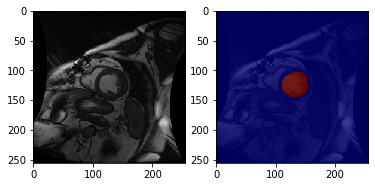

0.0
1.0


In [4]:
n = 0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_data.images[n,:,:,0], 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(train_data.images[n,:,:,0], 'gray', interpolation='none')
plt.imshow(train_data.labels[n,:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.show()

print(np.min(train_data.images))
print(np.max(train_data.images))

In [5]:
### Train/Val splitting

np.random.seed(10)
index = np.random.permutation(526)
#print(index)
### 526 -> 450 train, 76 val

x_train = train_data.images[index[0:450],:,:,:]
y_train = train_data.labels[index[0:450],:,:,:]
print(x_train.shape)

x_val = train_data.images[index[450:],:,:,:]
y_val = train_data.labels[index[450:],:,:,:]
print(x_val.shape)

(450, 256, 256, 1)
(76, 256, 256, 1)


In [6]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [7]:
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D
from keras.models import Model

In [8]:
bb = "vgg16"
input_shape = (256,256,3)
c = 1
enc_weights = "imagenet"
base_model = sm.Unet(backbone_name = bb, input_shape = input_shape, classes = c, activation='sigmoid', encoder_weights = enc_weights)

# define number of channels
N = x_train.shape[-1] # = 1
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

modelUnet = Model(inp, out, name=base_model.name)
modelUnet.compile('Adam', loss=dice_loss, metrics=[iou_score])

In [ ]:
ep = 100

# fit model
history = modelUnet.fit(
    x=x_train,
    y=y_train,
    batch_size=2,
    epochs=ep,
    validation_data=(x_val, y_val),
)

In [25]:
name =  str(ep) + "epochs.csv"
np.savetxt("loss_" + name,history.history['loss'])
np.savetxt("val_loss_" + name,history.history['val_loss'])
np.savetxt("iou_" + name,history.history['iou_score'])
np.savetxt("val_iou_" + name,history.history['val_iou_score'])

In [21]:
name = "modelUnet_100epochs.keras"
modelUnet.save(name)